In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tsa_bench as tsab

In [2]:
# --- Parameters ---
P = 10       # number of particles
T = 500      # time steps
D = 2        # sphere dimension (S^D in R^{D+1})
N = 20       # observation dimension
dt = 0.05
sigma_acc = 1.0
damping = 0.5
traj_noise_std = 0.01 #0.01
noise_std = 0.1 #0.1
seed = 42

data, meta = tsab.generate_sphere_benchmark(
    P=P, T=T, D=D, N=N, dt=dt,
    sigma_acc=sigma_acc, damping=damping,
    traj_noise_std=traj_noise_std,
    noise_std=noise_std, seed=seed,
)
print(f"Shuffled data shape: {data.shape}")
print(f"True trajectories shape: {meta['trajectories'].shape}")
print(f"Projection matrix shape: {meta['A'].shape}")

Shuffled data shape: (200, 500)
True trajectories shape: (10, 3, 500)
Projection matrix shape: (20, 3)


Trajectory norms — min: 0.9608653404, max: 1.0366470120


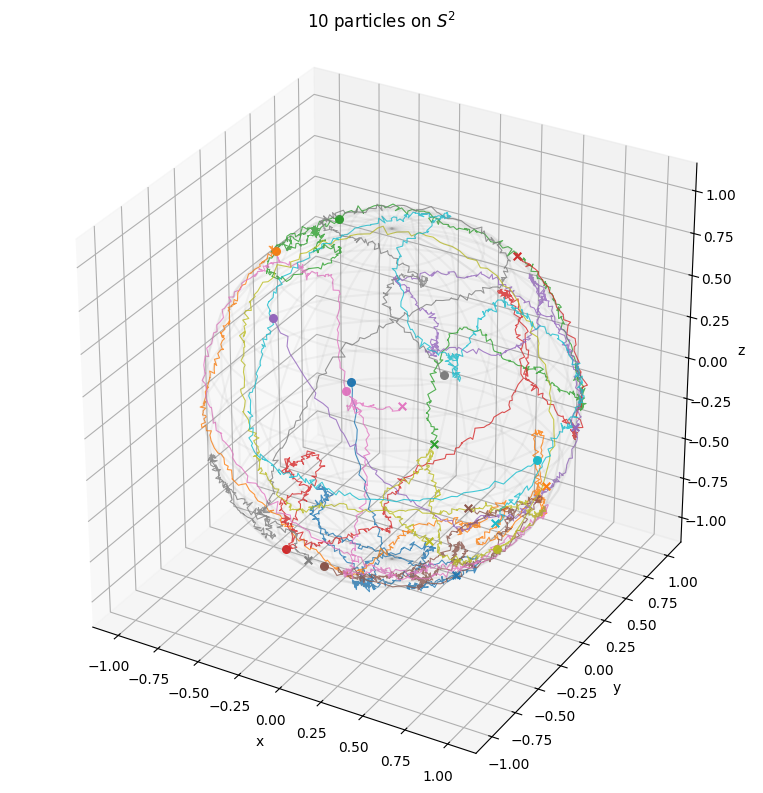

In [3]:
# --- Verify trajectories stay on sphere ---
norms = np.linalg.norm(meta['trajectories'], axis=1)  # (P, T)
print(f"Trajectory norms — min: {norms.min():.10f}, max: {norms.max():.10f}")

# --- 3D plot of true trajectories on S^2 (only when D=2) ---
if D == 2:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Wireframe sphere
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 20)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(xs, ys, zs, alpha=0.08, color='grey')
    
    cmap = plt.cm.tab10
    traj = meta['trajectories']  # (P, 3, T)
    for i in range(P):
        color = cmap(i % 10)
        ax.plot(traj[i, 0], traj[i, 1], traj[i, 2], color=color, lw=0.8, alpha=0.8)
        ax.scatter(*traj[i, :, 0], color=color, s=30, marker='o', zorder=5)   # start
        ax.scatter(*traj[i, :, -1], color=color, s=30, marker='x', zorder=5)  # end
    
    ax.set_title(f'{P} particles on $S^{D}$')
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
    ax.set_box_aspect([1, 1, 1])
    plt.tight_layout()
    plt.show()

elif D == 1:
    fig, ax = plt.subplots(figsize=(8, 4))
    theta = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), color='grey', alpha=0.5)  # unit circle
    cmap = plt.cm.tab10
    traj = meta['trajectories']  # (P, 2, T)
    for i in range(P):
        color = cmap(i % 10)
        ax.plot(traj[i, 0], traj[i, 1], color=color, lw=0.8, alpha=0.8)
        ax.scatter(*traj[i, :, 0], color=color, s=30, marker='o', zorder=5)   # start
        ax.scatter(*traj[i, :, -1], color=color, s=30, marker='x', zorder=5)  # end
    
    ax.set_title(f'{P} particles on $S^{D}$')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

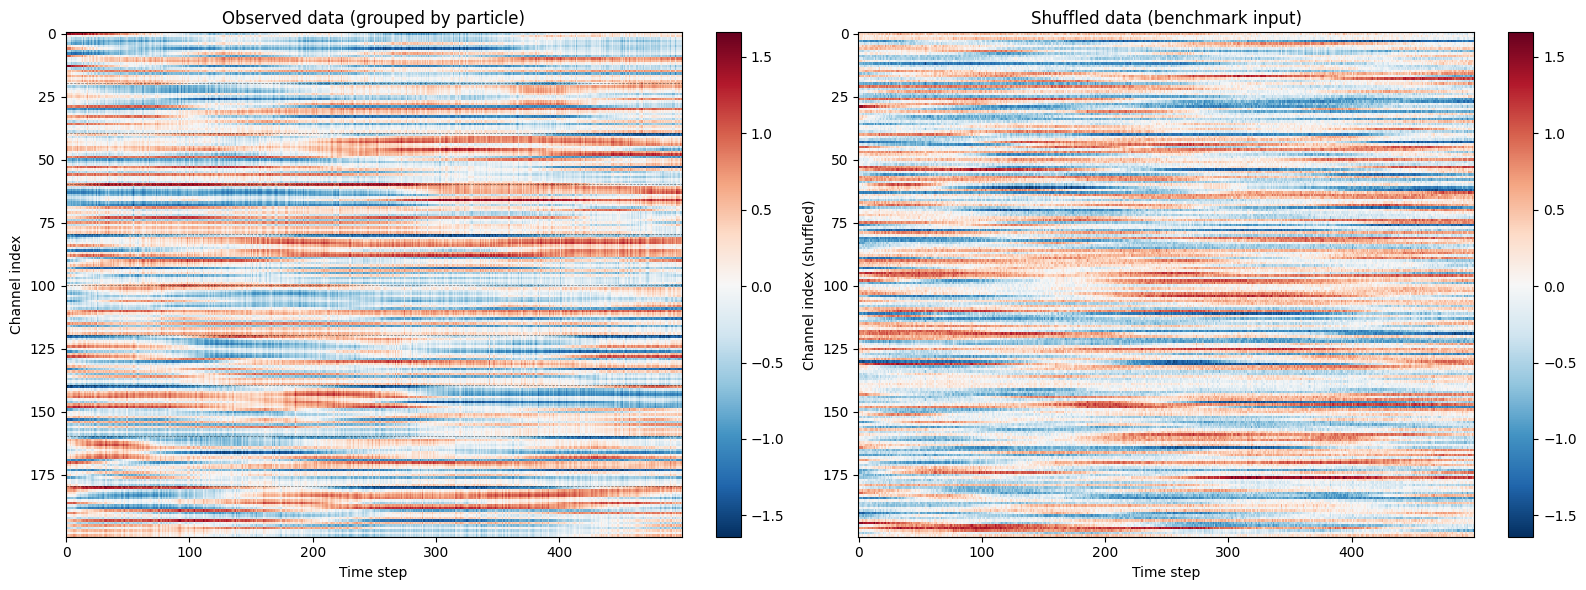

In [4]:
# --- Heatmap of observed data before and after shuffling ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before shuffle (grouped by particle)
observed_stacked = meta['observed'].reshape(P * N, T)
im0 = axes[0].imshow(observed_stacked, aspect='auto', cmap='RdBu_r', interpolation='nearest')
axes[0].set_title('Observed data (grouped by particle)')
axes[0].set_xlabel('Time step')
axes[0].set_ylabel('Channel index')
# Mark particle boundaries
for b in range(1, P):
    axes[0].axhline(b * N - 0.5, color='k', lw=0.5, ls='--', alpha=0.5)
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# After shuffle
im1 = axes[1].imshow(data, aspect='auto', cmap='RdBu_r', interpolation='nearest')
axes[1].set_title('Shuffled data (benchmark input)')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('Channel index (shuffled)')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()

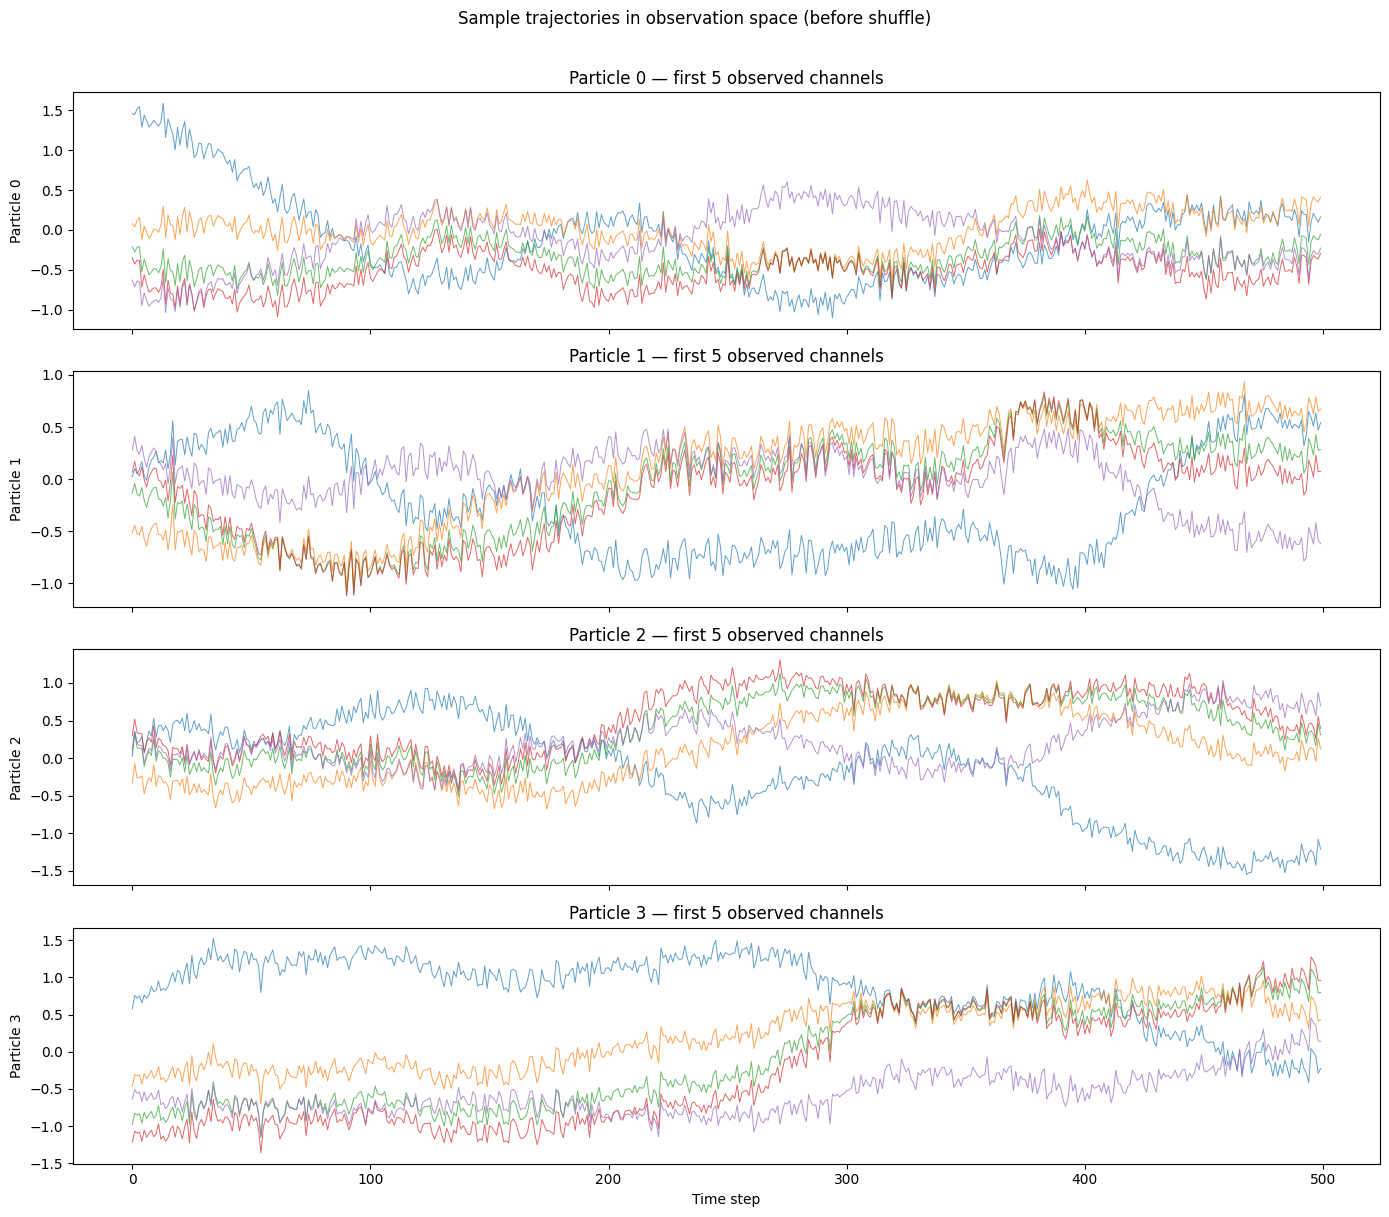

In [5]:
# --- Per-particle trajectory plots (first 3 components in observation space) ---
fig, axes = plt.subplots(min(P, 4), 1, figsize=(14, 3 * min(P, 4)), sharex=True)
if min(P, 4) == 1:
    axes = [axes]

cmap = plt.cm.tab10
for i, ax in enumerate(axes):
    obs_i = meta['observed'][i]  # (N, T)
    for j in range(min(N, 5)):
        ax.plot(obs_i[j], lw=0.7, alpha=0.7)
    ax.set_ylabel(f'Particle {i}')
    ax.set_title(f'Particle {i} — first 5 observed channels')

axes[-1].set_xlabel('Time step')
plt.suptitle('Sample trajectories in observation space (before shuffle)', y=1.01)
plt.tight_layout()
plt.show()

### CHALLENGE:
1. Can you recover the dynamic components? P(D+1)
2. Can you recover the number of particles?
3. Can you revocer the manifold dymension

# Analysis

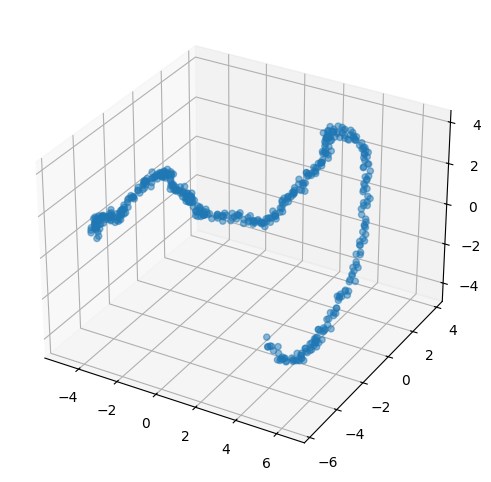

In [6]:
## Example - PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(data.T)
pca_data = pca.transform(data.T).T
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[0], pca_data[1], pca_data[2], alpha=0.5)
